# 2D-CNNs for MNIST dataset
* Learn about:
    * [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)
    * Coding with PyTorch Lightning
        * LightningDataModule
        * LightningModule
        * (optional) Logger, Trainer, callbacks
    * Two types of the artificial neuralnetworks
        * Multilayer perceptron (MLP)
        * 2D Convolutional neuralnetworks (2D CNNs)
* Let's try:
    * Build MLP or CNNs by yourself
    * Try to use other loss functions
    * Try to change the training parameters
        * learning rate, batch size, epochs, etc...

## Step1. Lightning data module for MNIST dataset ##

* `train_data`: 50,000
* `test_data`: 10,000
* `val_data`: 10,000

In [1]:
import os
import torch
from torch.utils.data import Dataset

from pytorch_lightning import LightningDataModule
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms
from typing import Optional


class MNISTDataset(LightningDataModule):
    def __init__(
        self,
        data_path: str,
        batch_size: int = 64
        ):
        super().__init__()
        self.data_dir = data_path
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))])
        self.batch_size = batch_size

    def setup(self, stage: Optional[str] = None) -> None:
        if stage == 'fit' or stage is None:
            full_data = MNIST(os.getcwd(), train=True,  download=True, transform=self.transform)
            self.train_data, self.val_data = random_split(full_data, [50000, 10000])
        if stage == 'test' or stage is None:
            self.test_data  = MNIST(os.getcwd(), train=False, download=True, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_data, batch_size=self.batch_size)        
    

## Step2-1. Multilayer perceptron (MLP) ##

In [2]:
from torch import nn

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(784, 256), # 28pixel x 28pixel = 784
            nn.ReLU(),
            #nn.Linear(256, 128),
            #nn.ReLU(),
            #nn.Linear(128, 64),
            #nn.ReLU(),
            nn.Linear(256, 10), # 10class
            nn.ReLU(),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        x = self.layer(x)
        return x

## Step2-2. 2D-CNNs model ##

In [3]:
from torch import nn

class CNNs2D(nn.Module):
    def __init__(self):
        super(CNNs2D, self).__init__()
        self.conv_layer = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, 3, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.2)
        )
        self.fc_layer = nn.Sequential(
            nn.Linear(9216, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 10), # 10Class
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
    def forward(self, x):
        x = self.conv_layer(x)
        x = torch.flatten(x,1)
        x = self.fc_layer(x)
        return x

## Step3. Pytorch lightning module ##

In [4]:
from torch.nn import functional as F
from torch import optim
from torch import Tensor
from torchmetrics.classification import Accuracy
from pytorch_lightning import LightningModule


class PLModuleMNIST(LightningModule):
    def __init__(self, model, lr_rate):
        super(PLModuleMNIST, self).__init__()
        self.model = model
        self.lr_rate = lr_rate
        self.accuracy_calc = Accuracy(task='multiclass', num_classes=10, top_k=1)

    def forward(self, input: Tensor, **kwargs) -> Tensor:
        return self.model(input)

    def cross_entropy_loss(self, x, y):
        return F.nll_loss(x, y)

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits,y)
        acc = self.accuracy_calc(logits, y)
        log = {'train_loss': loss, 'train_acc': acc}
        return {'loss': loss, 'acc': acc, 'logs': log}

        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits,y)
        acc = self.accuracy_calc(logits, y)
        log = {'val_loss': loss, 'val_acc': acc}
        return {'val_loss': loss, 'val_acc': acc, 'logs': log}

        
    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        loss = self.cross_entropy_loss(logits,y)
        acc = self.accuracy_calc(logits, y)
        log = {'test_loss': loss, 'test_acc': acc}
        return {'test_loss': loss, 'test_acc': acc, 'logs':log}
    
    def training_epoch_end(self, outputs) -> None:
        avg_loss = torch.stack( tuple(x['loss'] for x in outputs) ).mean()
        avg_acc = torch.stack( tuple(x['acc'] for x in outputs) ).mean()
        #print('train_loss:', avg_loss, 'train_acc', avg_acc)
        self.log('loss', {'train': avg_loss})
        self.log('acc', {'train': avg_acc})

    def validation_epoch_end(self, outputs) -> None:
        avg_loss = torch.stack( tuple(x['val_loss'] for x in outputs) ).mean()
        avg_acc = torch.stack( tuple(x['val_acc'] for x in outputs) ).mean()
        #print('val_loss:', avg_loss, 'val_acc', avg_acc)
        self.log('loss', {'val': avg_loss})
        self.log('acc', {'val': avg_acc})

    def test_epoch_end(self, outputs) -> None:
        avg_loss = torch.stack( tuple(x['test_loss'] for x in outputs) ).mean()
        avg_acc = torch.stack( tuple(x['test_acc'] for x in outputs) ).mean()
        #print('test_loss:', avg_loss, 'test_acc', avg_acc)
        self.log('loss', {'test': avg_loss})
        self.log('acc', {'test': avg_acc})

    def configure_optimizers(self):
        optimizer =  optim.Adam(self.parameters(), lr=self.lr_rate)
        lr_scheduler = {'scheduler': optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9), 'name': 'exp_LR'}
        return [optimizer], [lr_scheduler]
        #return optim.Adam(self.model.parameters(), lr=0.001)

## Step4. Logger ##
Tensorboard logger is used. A window of tensorboard opens here.

In [5]:
from pytorch_lightning.loggers import TensorBoardLogger

logger = TensorBoardLogger(save_dir='./tb_logs/', name = 'MNIST')


%reload_ext tensorboard
%tensorboard --logdir=./tb_logs/

Reusing TensorBoard on port 6006 (pid 12709), started 1:20:43 ago. (Use '!kill 12709' to kill it.)

## Step5. Build & fit a model ##
Select whether to use `MLP()` or `CNNs2D()` for the model. The settings for the learning is described here.
* `lr_rate`: learning rate
* `batch_size`
* `max_epochs`

In [6]:
model_core = CNNs2D() # or MLP()
model = PLModuleMNIST(model = model_core, lr_rate=0.001)
data = MNISTDataset(data_path = './', batch_size=128)

In [7]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar

runner = Trainer(max_epochs=10, 
                 #gpus=[0],
                 accelerator='cpu',  # or 'gpu', 'auto'
                 logger=logger, 
                 callbacks=[TQDMProgressBar(refresh_rate=10)])


runner.fit(model, data)

/vols/solid/dev_ubdt/local/pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ./tb_logs/MNIST


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw/train-images-idx3-ubyte.gz to /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw/train-labels-idx1-ubyte.gz to /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/hep/shayashi/work/students/example-pytorch-lightning/CNNs2D/MNIST/raw



LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type               | Params
-----------------------------------------------------
0 | model         | CNNs2D             | 1.2 M 
1 | accuracy_calc | MulticlassAccuracy | 0     
-----------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.800     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/vols/solid/dev_ubdt/local/pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/vols/solid/dev_ubdt/local/pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

/vols/solid/dev_ubdt/local/pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:290: UserWarning: The ``compute`` method of metric _ResultMetric was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## Step6. Check the trained model ##
* Structure of the model
* Classification performance for the test dataset
* Feature maps

#### Step6-1. Structure of the trained model ####

In [8]:
## You can load the trained model at the specific checkpoint
#model = PLModuleMNIST.load_from_checkpoint(model=model_core, lr_rate=0.001, checkpoint_path='./tb_logs/MNIST/version_0/checkpoints/epoch=2-step=1173.ckpt')

print(model)

PLModuleMNIST(
  (model): CNNs2D(
    (conv_layer): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Dropout(p=0.2, inplace=False)
    )
    (fc_layer): Sequential(
      (0): Linear(in_features=9216, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=128, out_features=10, bias=True)
      (4): ReLU()
      (5): Softmax(dim=1)
    )
  )
  (accuracy_calc): MulticlassAccuracy()
)


#### Step6-2. Classification perfromance for the test dataset ####
`Loss` and `Accuracy` are useful metrics for understanding the performance

In [9]:
runner.test(model, data)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/vols/solid/dev_ubdt/local/pyenv/versions/3.8.6/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        acc:test            0.9907041192054749
        loss:test           -0.9903149604797363
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'loss': {'test': tensor(-0.9903, device='cuda:0')},
  'acc': {'test': tensor(0.9907, device='cuda:0')}}]

#### Step6-3. Visualize the feature maps (2D-CNNs) ####

In [10]:
conv_layers = []
maxpooling_layers = []
children=list(model_core.children())
for child in children[0]:
    if (type(child) == nn.Conv2d) or (type(child) == nn.MaxPool2d):
        conv_layers.append(child)
    elif type(child) == nn.Sequential:
        for gen in list(child):
            for grandchildren in list(gen.children()):
                if (type(grandchildren) == nn.Conv2d) or (type(grandchildren) == nn.MaxPool2d):
                    conv_layers.append(grandchildren)
print('len(conv_layers):', len(conv_layers))

len(conv_layers): 3


##### Input image #####

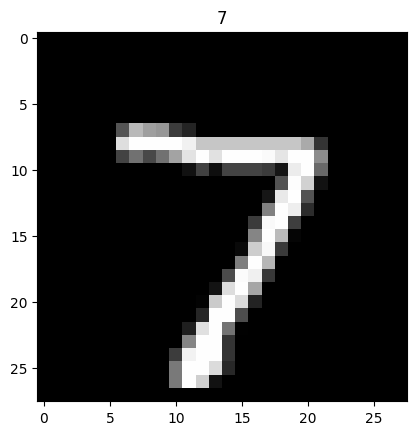

In [11]:
import matplotlib.pyplot as plt
mnist = MNIST(os.getcwd(), train=False,  download=True, transform= transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081))]))
sample_image, label = mnist[0]

plt.title('{}'.format(label))
plt.imshow(sample_image.numpy()[0], cmap='gray')

In [12]:
outputs_from_layer = []
img_from_prev_layer = sample_image
for layer in conv_layers:
    img_from_prev_layer = layer(img_from_prev_layer)
    outputs_from_layer.append(img_from_prev_layer)

(32, 26, 26)


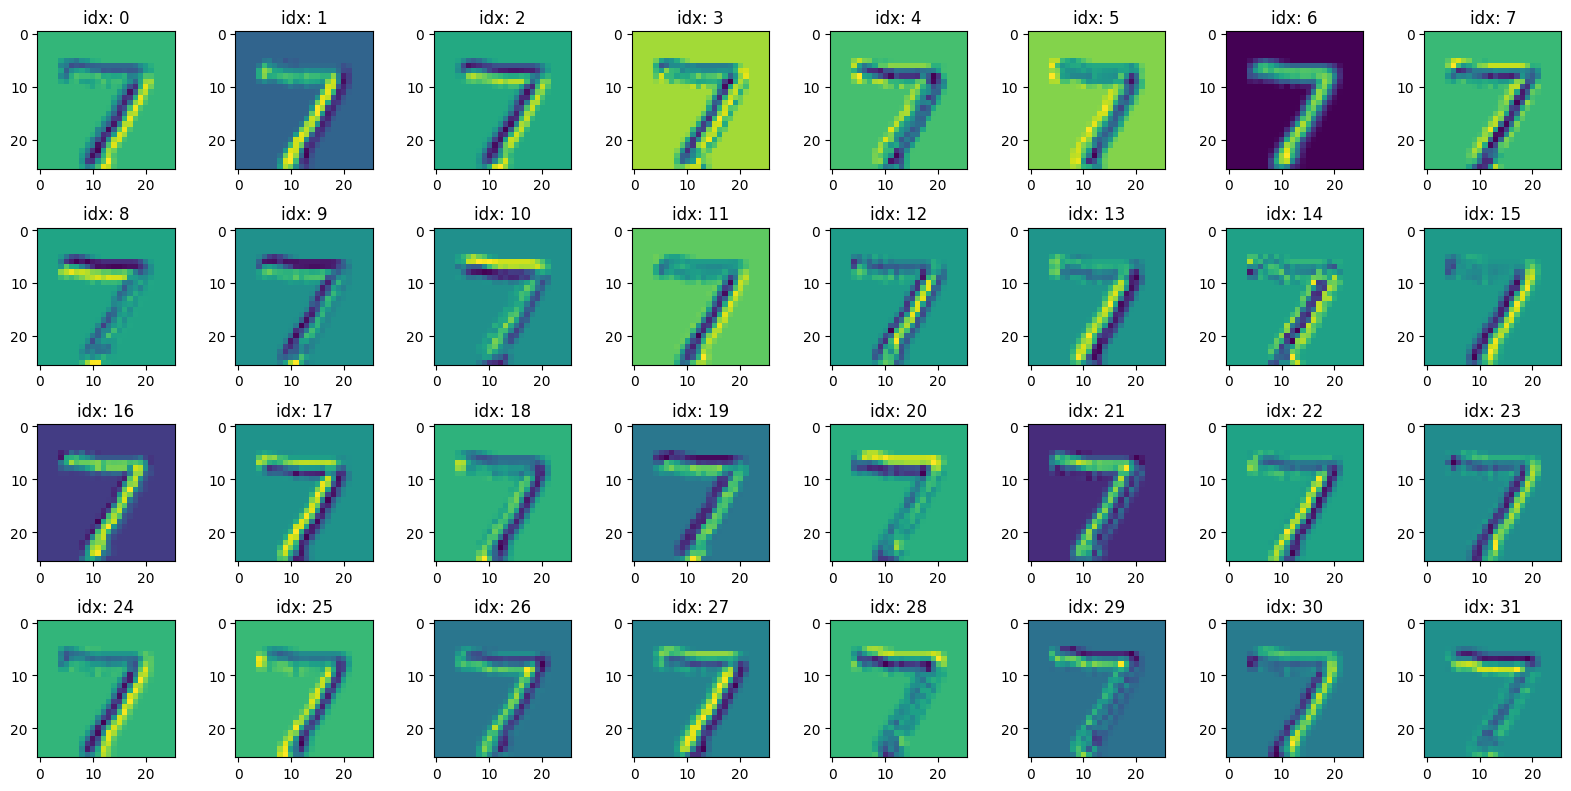

In [13]:
layer_number = 0
feature_maps = outputs_from_layer[layer_number].detach().numpy()
print(feature_maps.shape)
figs, axes = plt.subplots(4, 8, figsize=[16,8])
for i in range(feature_maps.shape[0]):
    feature_map = feature_maps[i,:,:]
    axes[int(i/8), int(i%8)].set_title('idx: {0}'.format(i))
    axes[int(i/8), int(i%8)].imshow(feature_map)

plt.tight_layout()
figs.show()

#### Find the most activd filter in the first Conv2d layer ####

Max, idx:  216.66313 30
Min, idx:  -164.83728 2


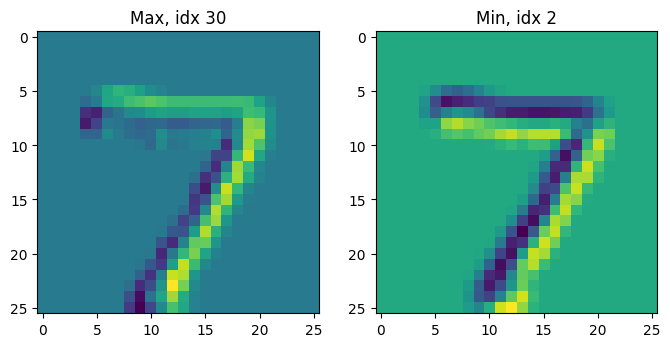

In [14]:
layer_number = 0
fmaps = outputs_from_layer[layer_number].detach().numpy()

output_from_filters = fmaps.sum(axis=2).sum(axis=1)
idx_max = output_from_filters.argmax()
max = output_from_filters.max()
idx_min = output_from_filters.argmin()
min = output_from_filters.min()

print('Max, idx: ', max, idx_max)
print('Min, idx: ', min, idx_min)

img_max = fmaps[idx_max,:,:]
img_min = fmaps[idx_min,:,:]

figs, axes = plt.subplots(1,2, figsize=[8,16])
axes[0].set_title('Max, idx {0}'.format(idx_max))
axes[0].imshow(img_max)
axes[1].set_title('Min, idx {0}'.format(idx_min))
axes[1].imshow(img_min)
figs.show()